## Import libraries and data, and create a baseline X and Y for modelling

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score,precision_score,f1_score
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.preprocessing import StandardScaler

In [188]:
cpdp = pd.read_pickle('complaints_timerestricted')

In [189]:
cpdp.set_index('cr_id',inplace=True)

In [190]:
cpdp.columns
cpdp.gender.fillna('Unknown',inplace=True)
cpdp.race.fillna('Unknown',inplace=True)
cpdp.numwitnesses.fillna(0,inplace=True)
cpdp.dropna(inplace=True)

In [ ]:
X=cpdp.drop(['appointed_date','cleaned_rannk','closed_date','complaint_date','complaint_category','complaint_code','cr_id','cv','final_finding','final_outcome','incident_date','link_uid','officer_birthyr','discipline'],axis=1)

In [ ]:
X= pd.get_dummies(X)
y=cpdp.discipline

## Dealing with imbalanced classes

### A naive model with no attempt to balance classes

First, I'm going to try a simple random forest and cross-validation and see how I do on accuracy and recall, to see if I need to do something to deal with my imbalanced classes (93% no discipline, 7% yes discipline).

In [ ]:
xtr, xte, ytr, yte = train_test_split(X, y, test_size=0.2)
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
rfc = RandomForestClassifier(n_estimators=20)

cross_val_score(rfc, xtr, ytr, # estimator, features, target
                cv=5, # number of folds 
                scoring='recall') # scoring metric

In [ ]:
cross_val_score(rfc, xtr, ytr, # estimator, features, target
                cv=5, # number of folds 
                scoring='accuracy') # scoring metric

WOW, NOT GREAT. 30% recall and 94% accuracy. Okay, let's fix it. I have 200k rows, so I think I can try oversampling and not break my computer.

In [ ]:
# I am only going to oversample from my training data, not my holdout

# Redo my train test split to stratify it
xtr, xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y)

### Try out oversampling first

In [ ]:
# Create new X and Y with resampled data
ros = RandomOverSampler(random_state=71)
X_resampled, y_resampled = ros.fit_sample(xtr,ytr)

In [ ]:
rfc = RandomForestClassifier(n_estimators=20)

cross_val_score(rfc, X_resampled, y_resampled, # estimator, features, target
                cv=5, # number of folds 
                scoring='recall') # scoring metric

In [ ]:
cross_val_score(rfc, X_resampled, y_resampled, # estimator, features, target
                cv=5, # number of folds 
                scoring='accuracy') # scoring metric

In [ ]:
model_o = rfc.fit(X_resampled,y_resampled)
predictions_o = model_o.predict(xte)
confusion_matrix(yte,predictions_o)

In [ ]:
precision_score(yte,predictions_o)

In [ ]:
recall_score(yte,predictions_o)

When I do oversampling, I get a lot false negatives. I don't like this - I want my model to catch as many incidents of discipline happening as possible, since it's such a rare event.

In [ ]:
f1_score(yte,predictions_o)

### Now let's try undersampling

In [ ]:
# Create new X and Y with undersampled data
X_under, y_under = RandomUnderSampler(random_state=42).fit_sample(xtr,ytr)

rfc = RandomForestClassifier(n_estimators=20)
model_u = rfc.fit(X_under,y_under)

In [ ]:
predictions_u = model_u.predict(xte)
confusion_matrix(yte,predictions_u)

In [ ]:
precision_score(yte,predictions_u)

In [ ]:
recall_score(yte,predictions_u)

In [ ]:
f1_score(yte,predictions_u)

When I do undersampling, I get fewer false negatives and more false positives, but I also get a lot more true positives (recall is okay). My F1 is about the same. I care more about recall (a model that leans on reform!), so I think I prefer undersampling. It makes things run a LOT faster - the risk is that it will make it hard to do analysis on small sub-populations of my data (like the post reform era - most of my data is pre-IPRA).

### Now I'll try SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(xtr,ytr)

In [ ]:
rfc = RandomForestClassifier(n_estimators=20)
model_sm = rfc.fit(X_smoted,y_smoted)

In [ ]:
predictions_sm = model_sm.predict(xte)
confusion_matrix(yte,predictions_sm)

In [ ]:
precision_score(yte,predictions_sm)

In [ ]:
recall_score(yte,predictions_sm)

In [ ]:
f1_score(yte,predictions_sm)

SMOTE does a better job balancing precision and recall, as evidenced by its higher F1 score. I still think I will want my data to be biased for sensitivity, especially since people will expect a model coming at poor police accountability to underpredict disciplinary rate.

## Selecting features

### Drop current unit

An initial look at feature importances showed me that my model was not learning a lot from 'current_unit'. Current_unit is a pretty dirty feature (cops move around as time goes on), and it adds a TON of complexity to my model, so I decided to lose it entirely.

In [ ]:
X=cpdp.drop(['appointed_date','cleaned_rannk','closed_date','complaint_date','complaint_category','complaint_code','cr_id','cv','final_finding','final_outcome','incident_date','link_uid','officer_birthyr','discipline','current_unit'],axis=1)

X= pd.get_dummies(X)
y=cpdp.discipline

xtr, xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y)

ros = RandomUnderSampler(random_state=71)
X_under, y_under = ros.fit_sample(xtr,ytr)

In [ ]:
rfc = RandomForestClassifier(n_estimators=20)
model = rfc.fit(X_under,y_under)

In [ ]:
predictions = model.predict(xte)
confusion_matrix(yte,predictions)

In [ ]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(xtr.columns, rfc.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})

importances.sort_values(by='Gini-importance').plot(kind='bar',figsize=(15,13));

In [ ]:
importances.sort_values(by='Gini-importance',ascending=False).head(60)

**time2close** (the amount of time the complaint is investigated before a conclusion is made) is a really important part of my model. 

Unfortunately, this is so intuitive it's almost useless - if a complaint is going to be thrown out, they settle it quickly, and if they are going to take it seriously, the investigation takes longer. What's more, a 'time2close' feature by definition is not available for unsettled complaints. I decide to build my model without it even though this will reduce my accuracy.

### Drop time2close even though it's really useful :(

In [ ]:
X=cpdp.drop(['appointed_date','cleaned_rannk','closed_date','complaint_date','complaint_category','complaint_code','cr_id','cv','final_finding','final_outcome','incident_date','link_uid','officer_birthyr','discipline','current_unit','time2close'],axis=1)

X= pd.get_dummies(X)
y=cpdp.discipline

xtr, xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y)

ros = RandomUnderSampler(random_state=71)
X_under, y_under = ros.fit_sample(xtr,ytr)

In [ ]:
rfc = RandomForestClassifier(n_estimators=20)
model = rfc.fit(X_under,y_under)

In [ ]:
predictions = model.predict(xte)
confusion_matrix(yte,predictions)

As a result of losing 'time2close', my model starts spitting out a lot more false positives. Hopefully I can fix this by trying different models and playing with parameters and other features.

In [ ]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(xtr.columns, rfc.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})

importances.sort_values(by='Gini-importance').plot(kind='bar',figsize=(15,13));

In [ ]:
xtr.columns

The columns for **race** and **gender** of the complainant do not seem to be super valuable, and also add a lot of complexity to my model. I am also missing those values for over half my dataset.

The **complainant code** also adds lots of complexity, and a lot of that information could be engineered in simpler features (as done already in the 'injury','not_operations', etc) columns. I went back and created two new columns to see if I could capture the complaint_code more simply. 'COPA Style' holds complain

**time2complain** gives me negative numbers, that's not good. Don't know why I missed that. Let's lose it.

### Drop complainant race, gender, month, and the complaint code

In [191]:
X=cpdp.drop(['appointed_date','cleaned_rannk','closed_date','complaint_date','complaint_category','complaint_code','cv','final_finding','final_outcome','incident_date','link_uid','officer_birthyr','discipline','current_unit','time2close','number_complaint_code','race','gender','incident_month','time2complain'],axis=1)

X= pd.get_dummies(X)
y=cpdp.discipline

xtr, xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y)

ros = RandomUnderSampler(random_state=71)
X_under, y_under = ros.fit_sample(xtr,ytr)

In [ ]:
rfc = RandomForestClassifier(n_estimators=20)
rfc.fit(X_under,y_under)

In [ ]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(xtr.columns, rfc.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})

importances.sort_values(by='Gini-importance').plot(kind='bar',figsize=(15,13));

## Choosing models and parameters

### Naive Models

I'm going to just try some very simple models and see what kind of results I get.

In [ ]:
logit = LogisticRegression()
cross_val_score(logit, X_under, y_under, # estimator, features, target
                cv=5, # number of folds 
                scoring='recall') # scoring metric

In [ ]:
cross_val_score(logit, X_under, y_under, # estimator, features, target
                cv=5, # number of folds 
                scoring='roc_auc') # scoring metric

In [ ]:
rfc = RandomForestClassifier(n_estimators=20,max_depth=5)
cross_val_score(rfc, X_under, y_under, # estimator, features, target
                cv=5, # number of folds 
                scoring='recall') # scoring metric

In [ ]:
rfc = RandomForestClassifier(n_estimators=20,max_depth=5)
cross_val_score(rfc, X_under, y_under, # estimator, features, target
                cv=5, # number of folds 
                scoring='roc_auc') # scoring metric

A default logistic regression does better than a default RFC, but RFC gets better when I play with the parameters. Let's tune logistic and keep that as our baseline, and come back to RFC after we've checked some others.

### Look for the best C for a Logistic regression

In [ ]:
# Use a for loop to optimize C for undersampled data
cList = [.001,.01, .1, 1, 10, 100, 1000]

for c in cList:
    logit=LogisticRegression(C=c)
    logit.fit(X_under, y_under)
    scoreRec = cross_val_score(logit, X_under, y_under, # estimator, features, target
                cv=5, # number of folds 
                scoring='recall').mean()
    scoreROC = cross_val_score(logit, X_under, y_under, # estimator, features, target
                cv=5, # number of folds 
                scoring='roc_auc').mean()
    print("C {} yields a recall of {} and a roc-auc of {}".format(c,scoreRec,scoreROC))

It seems like C doesn't really change much and the default of 1 is pretty okay.

### Try and find the best K for K nearest neighbors

In [ ]:
emptyklist = []
for k in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_under,y_under)
    ypreds = knn.predict(xte)
    emptyklist.append(recall_score(yte,ypreds))

In [ ]:
max(emptyklist)

The best K neighbors score SUCKS compared to logistic, so let's leave KNeighbors behind.

### How about a Naive Bayes of some kind?

I have 14 continuous columns and 17 binary columns, so I'll try Gaussian and Bernoulli.

In [ ]:
nb = BernoulliNB()
nb.fit(X_under,y_under)
cross_val_score(nb, X_under, y_under, # estimator, features, target
                cv=5, # number of folds 
                scoring='recall') # scoring metric

In [ ]:
nb = GaussianNB()
nb.fit(X_under,y_under)
cross_val_score(nb, X_under, y_under, # estimator, features, target
                cv=5, # number of folds 
                scoring='recall') # scoring metric

The scoring for both naive Bayes models is worse than my baseline logistic regression, so let's put this one aside.

### How about a SVC? My datasets a little too big, so let's just look at Linear.

In [ ]:
# 1. Create a suppor vector classifier model
model_svm = svm.LinearSVC()
# 2. Fit a model on the training data
model_svm.fit(X_under, y_under)
cross_val_score(model_svm, X_under, y_under, # estimator, features, target
                cv=5, # number of folds 
                scoring='recall') # scoring metric

Wow, SVM is all over the place. That's scary AF. Screw that, let's go back to random forests.

### Random Forest - tune for the number of estimators.

In [ ]:
nlist = []
for n in range(1,300):
    rfc = RandomForestClassifier(n_estimators=n)
    model = rfc.fit(X_under,y_under)
    score = cross_val_score(model, X_under, y_under, # estimator, features, target
                cv=3, # number of folds 
                scoring='recall').mean()
    nlist.append(score)
    print(n, score) # scoring metric
    

Based on the output, the number of estimators stops adding value around 30, so let's just use that.

In [ ]:
dlist =[]
for d in range(1,40):
    rfc = RandomForestClassifier(n_estimators=30,max_depth=d)
    model = rfc.fit(X_under,y_under)
    score = cross_val_score(model, X_under, y_under, # estimator, features, target
                cv=3, # number of folds 
                scoring='recall').mean()
    dlist.append(score)
    print(d, score) # scoring metric

Based on the output of this loop, the max_depth stops adding value around 12-15, so let's just use that.

Now let's compare our tuned random forest to our tuned logistic regression!

In [ ]:
rfc=RandomForestClassifier(n_estimators=30,max_depth=12)
model = rfc.fit(X_under,y_under)
cross_val_score(model, X_under, y_under, # estimator, features, target
                cv=5, # number of folds 
                scoring='roc_auc').mean()

In [ ]:
logit = LogisticRegression(C=1,solver='liblinear')
cross_val_score(logit, X_under, y_under, # estimator, features, target
                cv=5, # number of folds 
                scoring='roc_auc').mean()

Okay, so it looks like we are probably going to do a RandomForest! We'll come back to this.

## Using Class Weighting to Solve Imbalance problem

I'm not super happy with how under-sampling dealt with my class imbalance problem, since I'm currently getting more false positives than I like, and I don't like throwing out so much of my data to balance my classes. I want to try penalizing misclassifications, using my raw data.

In [ ]:
lr_balanced = LogisticRegression(solver='liblinear',class_weight='balanced')
cross_val_score(lr_balanced, xtr, ytr, # estimator, features, target
                cv=5, # number of folds 
                scoring='roc_auc').mean()

In [ ]:
lr = LogisticRegression(solver='liblinear')
cross_val_score(lr, X_under, y_under, # estimator, features, target
                cv=5, # number of folds 
                scoring='roc_auc').mean()

The baseline 'balanced' parameter improves my score by .003. Let's try heavily emphasizing my minority class.

Let's do a quick for loop to optimize for my class weights. This will be with no resampling, just on my raw data.

In [ ]:
for w in range(1,20):
    lr_4x = LogisticRegression(C=1,solver='liblinear',class_weight={1 : w, 0 : 1})
    scoreRec = cross_val_score(lr_4x, xtr, ytr, # estimator, features, target
                cv=3, # number of folds 
                scoring='recall').mean()
    scoreROC = cross_val_score(lr_4x, xtr, ytr, # estimator, features, target
                cv=3, # number of folds 
                scoring='roc_auc').mean()
    print("W {} yields a recall of {} and a roc-auc of {}".format(w,scoreRec,scoreROC))

Around a weight of 15:1, I start to see a decrease in roc-auc score to go with my increased recall score, so I'll stop there. I'll try using these class-weights with some other models and see if I get improved results.

For a logistic regression, I'm not really getting better results than I did with undersampling, but this seems at least a little more honest data-wise. 

It also like the synchronicity that my imbalance is about a 15:1 ratio, and the inverse weighting corrects it.

## Optimizing Random Forest

Now that I think I want to use class-weighting rather than under-sampling, I'll go about optimizing parameters in a RandomForest model and determine if it is better than a Logistic Regression.

In [ ]:
# build a classifier
clf = RandomForestClassifier()

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")



I'll look at a variety of depths, a variety of max_features, a variety of estimators, and a variety of class_weights to see what will be best for my model.

In [ ]:
# specify parameters and distributions to sample from
param_dist = {"max_depth": list(range(1,20)),
                "n_estimators":list(range(1,30)),
             "class_weight":[{1 : 7, 0 : 1},{1 : 10, 0 : 1},{1 : 12, 0 : 1},{1 : 15, 0 : 1},{1 : 18, 0 : 1}]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False,scoring='roc_auc')
random_search.fit(xtr, ytr)
report(random_search.cv_results_)

In [150]:
opt_rfc = RandomForestClassifier(n_estimators=20,max_depth=9,class_weight={1:10,0:1})
modelrfc = opt_rfc.fit(xtr,ytr)

In [151]:
ypred=modelrfc.predict(xte)
confusion_matrix(yte,ypred)

array([[22327,  1576],
       [  380,   967]])

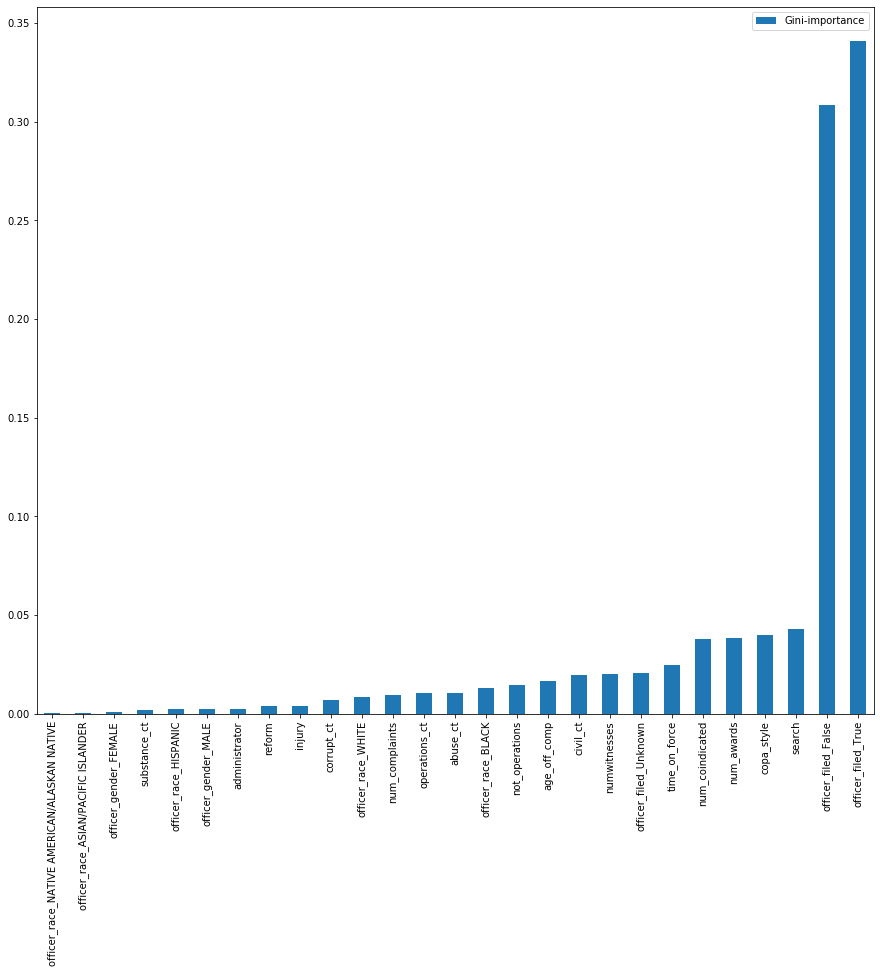

In [152]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(xtr.columns, modelrfc.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})

importances.sort_values(by='Gini-importance').plot(kind='bar',figsize=(15,13));

## Optimize LogisticRegression and choose features for a simplified model for the app

In [248]:
std = StandardScaler()
std.fit(xtr.values)
xsc = std.transform(xtr.values)
xtesc = std.transform(xte.values)

In [256]:
logit = LogisticRegression(solver='liblinear',class_weight={1:12,0:1})
model_log = logit.fit(xtr,ytr)
ypred = model_log.predict(xte)
confusion_matrix(yte,ypred)

array([[18879,  1475],
       [  305,   852]])

In [258]:
pickle.dump(model_log, open('logistic_model.p', 'wb'))

In [194]:
recall_score(yte,ypred)

0.7363872082973206

In [221]:
accuracy_score(yte,ypred)

0.9170191994793362

In [222]:
coefs = (model_log.coef_[0]).tolist()
xtrcol = xtr.columns.tolist()

scaled_logit_coefs = list(zip(xtrcol,coefs))

In [225]:
scaled_logit_coefs

[('abuse_ct', -0.6738347910638444),
 ('age_off_comp', 0.10147725585558061),
 ('civil_ct', -0.9494015045163684),
 ('corrupt_ct', -0.09928988352531136),
 ('num_awards', -0.1842247424927668),
 ('num_coindicated', -0.05136672112885396),
 ('num_complaints', 1.6573010111281385),
 ('numwitnesses', 0.3576146082808356),
 ('operations_ct', -0.40750905302942286),
 ('substance_ct', 0.0312012434843354),
 ('time_on_force', -0.11829975169351813),
 ('not_operations', 0.15099110267900717),
 ('injury', 0.003220609262844392),
 ('administrator', -0.1101159686413002),
 ('copa_style', -0.26577038407289255),
 ('search', -0.8356803335395285),
 ('reform', -0.28929486156892836),
 ('officer_filed_False', -0.45361609299890704),
 ('officer_filed_True', 0.537863088629363),
 ('officer_filed_Unknown', -0.23890269488073515),
 ('officer_gender_FEMALE', 0.01729263461667737),
 ('officer_gender_MALE', -0.017292634616626414),
 ('officer_race_ASIAN/PACIFIC ISLANDER', 0.011532620554371514),
 ('officer_race_BLACK', 0.08838423

## Rebuild a simpler Random Forest model with minimal features to make the Flask app more user friendly

In [339]:
cpdp['officer_age']=cpdp['age_off_comp']//365
cpdp['yrs_force']=cpdp['time_on_force']//365
X=cpdp.drop(['appointed_date','age_off_comp','time_on_force','discipline','cleaned_rannk','closed_date','complaint_date','complaint_category','complaint_code','cv','final_finding','final_outcome','incident_date','link_uid','officer_birthyr','current_unit','time2close','number_complaint_code','race','gender','incident_month','time2complain',"officer_gender",'officer_race','substance_ct','num_coindicated','administrator','injury','corrupt_ct','not_operations'],axis=1)


X= pd.get_dummies(X)
y=cpdp.discipline

xtr, xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y)


In [340]:
opt_rfc = RandomForestClassifier(n_estimators=20,max_depth=9,class_weight={1:10,0:1})
modelrfc = opt_rfc.fit(xtr,ytr)

ypred=modelrfc.predict(xte)
confusion_matrix(yte,ypred)


array([[18997,  1357],
       [  317,   840]])

In [341]:
recall_score(yte,ypred)

0.7260155574762316

In [379]:
pickle.dump(modelrfc, open('modelrfc.p', 'wb'))

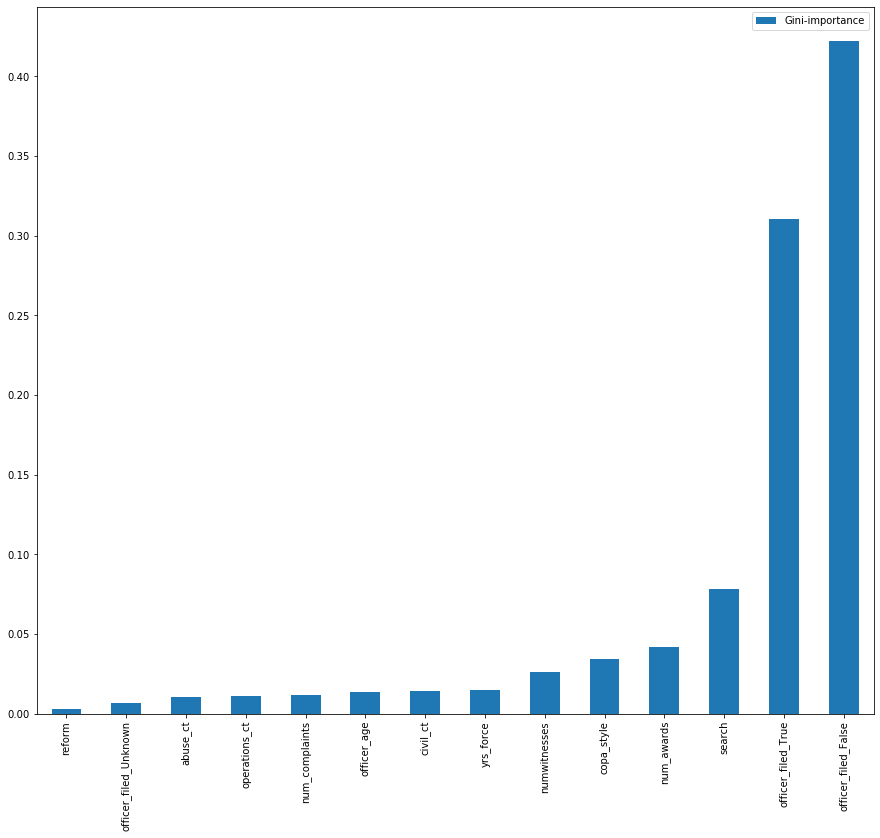

In [342]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(xtr.columns, modelrfc.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})

importances.sort_values(by='Gini-importance').plot(kind='bar',figsize=(15,13));

## Make a smaller dataframe that contains small, class-balanced subsamples of my data for datavis

In [198]:
X2=cpdp.drop(['appointed_date','cleaned_rannk','closed_date','complaint_category','complaint_code','cv','final_finding','final_outcome','incident_date','link_uid','officer_birthyr','current_unit','time2close','number_complaint_code','race','gender','incident_month','time2complain'],axis=1)
X2= pd.get_dummies(X2)
all_disc = X2[X2['discipline']==1]
no_disc = X2[X2['discipline']==0]

In [199]:
rand_YesDisc = all_disc.sample(400,random_state=23)
rand_NoDisc = no_disc.sample(400,random_state=23)

In [200]:
test = pd.concat([rand_YesDisc,rand_NoDisc])

In [218]:
yte[yte==0].shape

(20354,)

In [217]:
test.to_csv('tryout_vis.csv')

## Making predictions on undecided or unknown complaints

In [364]:
# Do some touch up cleaning on the unknown complaints, and get it ready for modelling
unk = pd.read_pickle('data/unknown_complaints')
unk.set_index('cr_id',inplace=True)

unk['age_off_comp']=unk['age_off_comp'].dt.days
unk['time_on_force']=unk['time_on_force'].dt.days
unk['officer_age']=unk['age_off_comp']//365
unk['yrs_force']=unk['time_on_force']//365
unk_X= unk.drop(['numcomplainants','appointed_date','age_off_comp','uid','time_on_force','cleaned_rannk','closed_date','complaint_date','complaint_category','complaint_code','cv','final_finding','final_outcome','incident_date','link_uid','officer_birthyr','current_unit','time2close','number_complaint_code','incident_month','time2complain',"officer_gender",'officer_race','substance_ct','num_coindicated','administrator','injury','corrupt_ct','not_operations'],axis=1)
unk_X = pd.get_dummies(unk_X)
unk_X['officer_filed_Unknown']=0
unk_X.numwitnesses.fillna(0,inplace=True)
unk_X.dropna(inplace=True)

In [373]:
# Limit the data to post-IPRA complaints to avoid criticism like "it's all changed since IPRA"
unk_X_r =unk_X[unk_X['reform']==1]

In [312]:
unk_pred = modelrfc.predict(unk_X_r)
unk_X_r['predictions']=unk_pred
unk_X_r.predictions.mean()

In [386]:
# What percent of unknown complaints does the model think should lead to discipline?
unk_X_r

,numwitnesses,num_awards,num_complaints,operations_ct,civil_ct,abuse_ct,reform,copa_style,search,officer_age,yrs_force,officer_filed_False,officer_filed_True,officer_filed_Unknown,predictions
cr_id,,,,,,,,,,,,,,,
1017454,1.0,82.0,9.0,3.0,3.0,2.0,1,0,0,50,4,1,0,0,0
1070814,4.0,165.0,20.0,3.0,9.0,7.0,1,1,1,32,6,1,0,0,0
1048715,2.0,39.0,30.0,16.0,3.0,10.0,1,0,0,40,9,1,0,0,0
1078293,4.0,11.0,2.0,1.0,0.0,0.0,1,0,0,36,2,0,1,0,0
1067835,2.0,45.0,17.0,10.0,1.0,6.0,1,1,0,46,17,1,0,0,0
1015971,0.0,66.0,16.0,11.0,4.0,1.0,1,0,0,33,4,1,0,0,0
1077887,2.0,141.0,15.0,5.0,5.0,4.0,1,1,1,45,8,1,0,0,0
1057800,2.0,53.0,63.0,9.0,27.0,23.0,1,1,0,37,10,1,0,0,0
1053884,2.0,207.0,13.0,1.0,5.0,5.0,1,1,1,31,7,1,0,0,0
